In [2]:
import os
import sys

SPARK_HOME = "/usr/lib/spark3"
PYSPARK_PYTHON = "/opt/conda/envs/dsenv/bin/python"
os.environ["PYSPARK_PYTHON"]= PYSPARK_PYTHON
os.environ["PYSPARK_DRIVER_PYTHON"]= PYSPARK_PYTHON
os.environ["SPARK_HOME"] = SPARK_HOME

PYSPARK_HOME = os.path.join(SPARK_HOME, "python/lib")
sys.path.insert(0, os.path.join(PYSPARK_HOME, "py4j-0.10.9.5-src.zip"))
sys.path.insert(0, os.path.join(PYSPARK_HOME, "pyspark.zip"))

In [3]:
from pyspark import SparkConf
from pyspark.sql import SparkSession

conf = SparkConf()
conf.set("spark.ui.port", "12941")

spark = SparkSession.builder.config(conf=conf).appName("Spark next part").getOrCreate()

Picked up _JAVA_OPTIONS: 
Picked up _JAVA_OPTIONS: 
SLF4J: Class path contains multiple SLF4J bindings.
SLF4J: Found binding in [jar:file:/usr/lib/spark3/jars/log4j-slf4j-impl-2.17.2.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: Found binding in [jar:file:/usr/lib/hadoop/lib/slf4j-log4j12-1.7.25.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: See http://www.slf4j.org/codes.html#multiple_bindings for an explanation.
SLF4J: Actual binding is of type [org.apache.logging.slf4j.Log4jLoggerFactory]
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


24/04/26 11:29:37 WARN YarnSchedulerBackend$YarnSchedulerEndpoint: Attempted to request executors before the AM has registered!


# Apache Spark part 2. Spark ML, RDD, CLI
# /opt/shared/
## План лекции
### 1. Вспоминаем, что такое Spark
### 2. Разбираем остатки Spark SQL
### 3. Изучаем Spark MLlib
## Если останется время
### 4. Исследуем Spark UI
### 5. Исследуем Spark CLI
### 6. Исследуем по Spark RDD

# 1. Apache Spark

### Анатомия приложения
**Application**

Непосредственно наше приложение, написанное с помощью Spark API. Состоит из драйвера и экзекуторов.

**SparkSession**

Объект, которые обеспечивает нам точку взаимодействия с функционалом Spark и непосредственно позволяет работать с API. 

**Job**

Параллельное исполнение множесства задача (tasks), создаваемые в результате вызова actions.


**Stage**

Этапы, на которые разбивается Job, включаюшие в себя зависимые задачи.


**Task**

Единица исполнения на экзекуторе

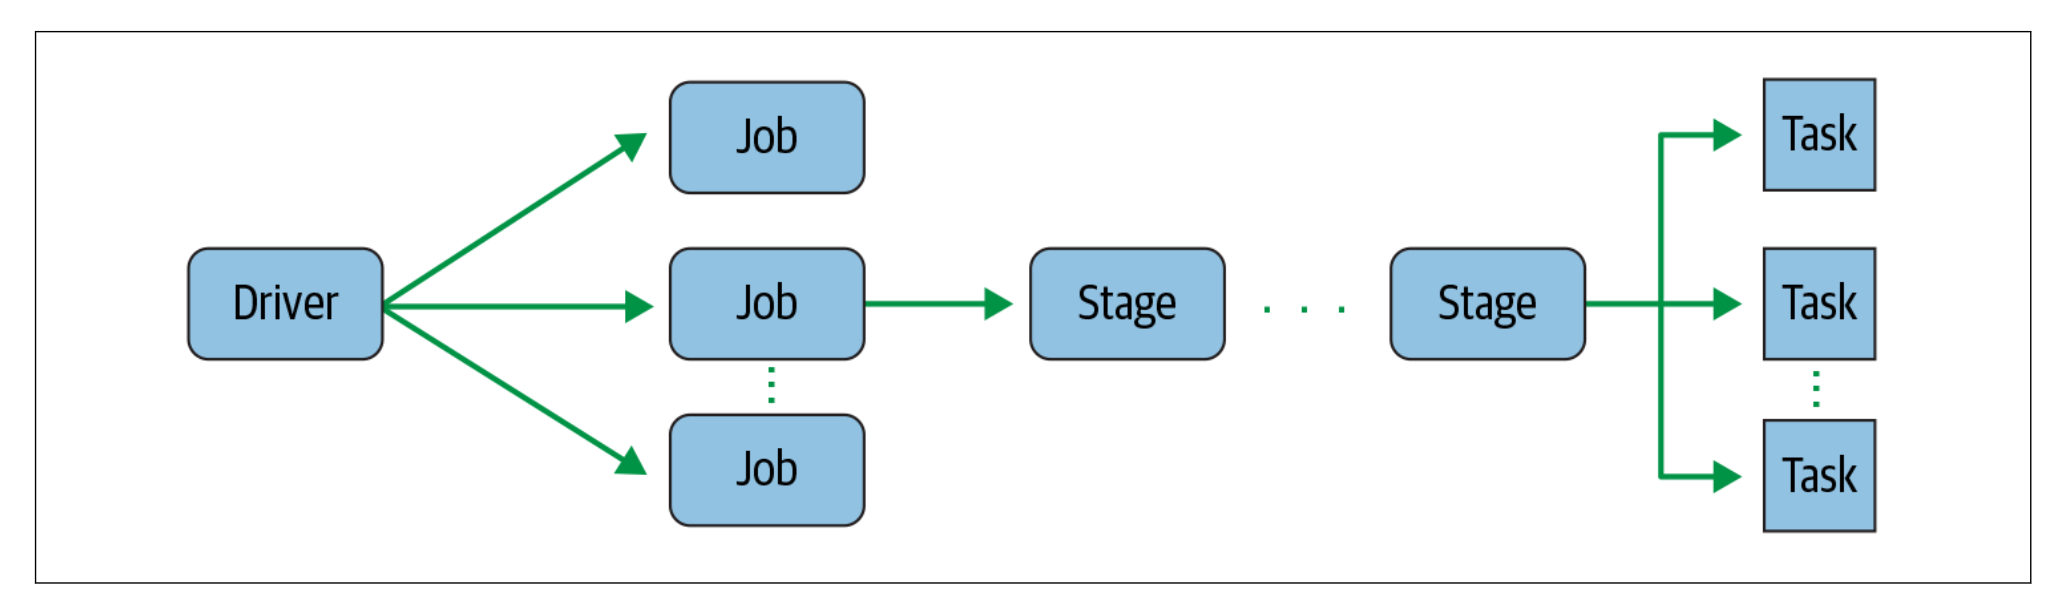

### Ключевые концепции
* Actions
* Transformations (wide & narrow)
* Lazy evaluation
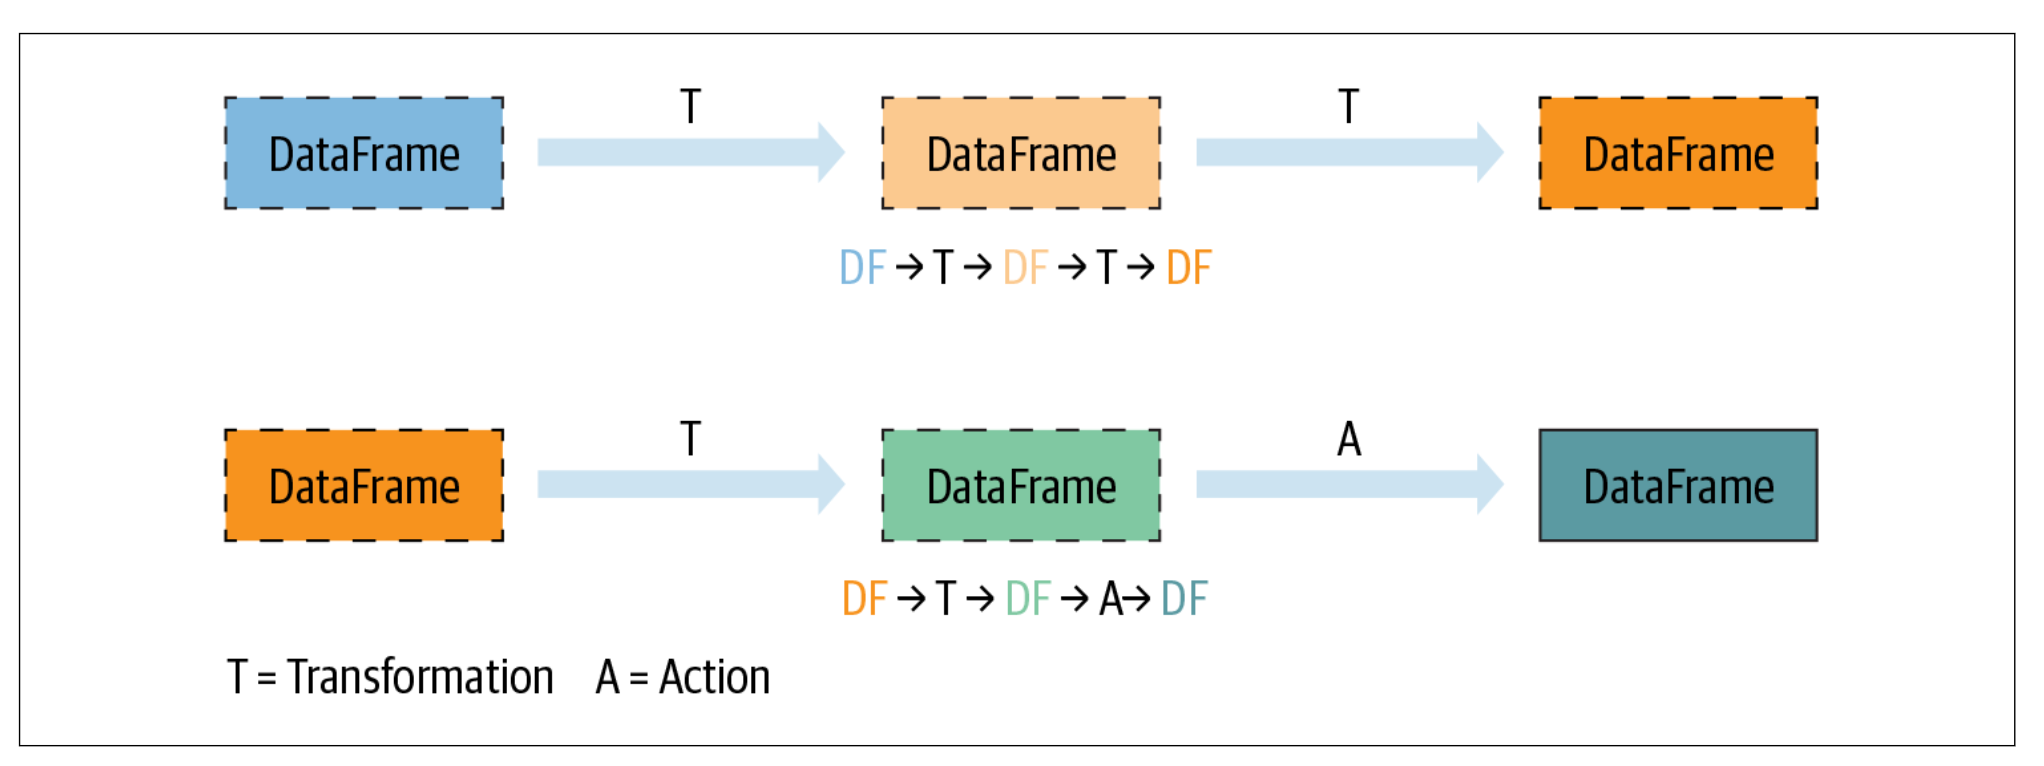

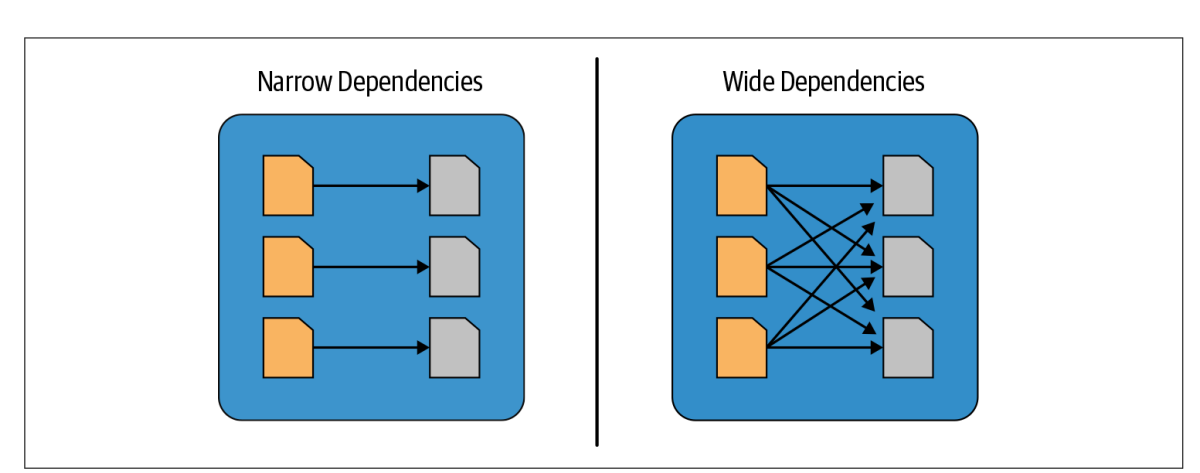

# 2. Spark SQL. Продолжение.

## Подсчет числа пользовательских сессий
Вам необходимо подсчитать число пользовательских сессий в разбивке по доменам на данных из лог-файла.

**Пользовательская сессия** - это пребывание пользователя на сайте такое, что между двумя последовательными кликами проходит не более 30 минут.
Лог-файл такой же, как и на лекции. Находится в HDFS по пути `/datasets/logs/logsM.txt`

### Задание №1
Создайте `DataFrame` из лог-файла. Схему можно скопировать из лекции.

In [3]:
from pyspark.sql.types import *

In [4]:
import pyspark.sql.functions as f

In [9]:
log_schema = StructType(fields=[
    StructField("ip", StringType()),
    StructField("timestamp", LongType()),
    StructField("url", StringType()),
    StructField("size", IntegerType()),
    StructField("code", IntegerType()),
    StructField("ua", StringType())
])
log = spark.read.csv("/datasets/logs/logsM.txt", sep="\t", schema=log_schema)

NameError: name 'spark' is not defined

In [6]:
log.show()

+---------------+--------------+--------------------+----+----+--------------------+
|             ip|     timestamp|                 url|size|code|                  ua|
+---------------+--------------+--------------------+----+----+--------------------+
|  89.107.195.67|20221119114314|https://www.ozon....|5012| 200|Mozilla/5.0 (Linu...|
|  83.234.104.18|20230403193037|https://www.ozon....|5046| 200|Mozilla/5.0 (Wind...|
| 194.186.145.33|20221005070928|https://www.wildb...|4981| 303|Mozilla/5.0 (Wind...|
|176.194.131.146|20230430030259|https://www.wildb...|4996| 502|Mozilla/5.0 (Maci...|
|   77.82.188.89|20221102230855|https://www.wildb...|5011| 200|Mozilla/5.0 (Maci...|
|109.165.113.208|20220613094920|https://www.wildb...|4935| 404|Mozilla/5.0 (Linu...|
|212.193.174.211|20230916214057|https://www.ozon....|4882| 304|Mozilla/5.0 (iPho...|
|109.165.113.208|20220302102519|https://www.wildb...|5114| 304|Mozilla/5.0 (Andr...|
|188.234.192.226|20220910182109|https://www.wildb...|4919| 404|Mo

### Задание №2
Лог не содержит столбца с доменом. Конечно можно извлечь домен с помощью функции [regexp_extract](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.functions.regexp_extract), но мы так делать не будем. Напишите `pandas_udf`, которая будет извлекать домены из столбца `url`. Результаты применения функции поместите в столбец `domain`.

Для извлечения домена можно воспользоваться функцией [urlparse](https://docs.python.org/3/library/urllib.parse.html#urllib.parse.urlparse)

In [7]:
from urllib.parse import urlparse

@f.pandas_udf(StringType())
def encode_domain(url):
    return url.apply(lambda x: urlparse(x).hostname)

In [8]:
log.withColumn("domain", encode_domain("url")).show(5)

+---------------+--------------+--------------------+----+----+--------------------+------------------+
|             ip|     timestamp|                 url|size|code|                  ua|            domain|
+---------------+--------------+--------------------+----+----+--------------------+------------------+
|  89.107.195.67|20221119114314|https://www.ozon....|5012| 200|Mozilla/5.0 (Linu...|       www.ozon.ru|
|  83.234.104.18|20230403193037|https://www.ozon....|5046| 200|Mozilla/5.0 (Wind...|       www.ozon.ru|
| 194.186.145.33|20221005070928|https://www.wildb...|4981| 303|Mozilla/5.0 (Wind...|www.wildberries.ru|
|176.194.131.146|20230430030259|https://www.wildb...|4996| 502|Mozilla/5.0 (Maci...|www.wildberries.ru|
|   77.82.188.89|20221102230855|https://www.wildb...|5011| 200|Mozilla/5.0 (Maci...|www.wildberries.ru|
+---------------+--------------+--------------------+----+----+--------------------+------------------+
only showing top 5 rows



### Задание №3
Для разминки давайте подсчитаем сколько дней прошло между первым и последним посещением пользователем нашего домена. Будем считать, что интересующий нас домен ` www.ozon.ru`. В качестве "уникального" идентификатора пользователя договоримся использовать ip-адрес. Использовать оконные функции в данном задании не надо!

#### Задание №3.1
Для выполнения задания №3 понадобится делать операции с датами. Заметьте, что в столбце `timestamp` хранится не настоящий timestamp, а число с датой в формате "yyyyMMddHHmmss". Используя функции из `pyspark.sql.functions`, создайте новый столбец `timestamp`, содержащий в себе UNIX timestamp.

При возникновении ошибок, обратите внимание на типы данных. Возможно их нужно привести.

In [9]:
log.show(10, False)

+---------------+--------------+--------------------------------------------+----+----+---------------------------------------------------------------------------------------------------------------------------------------------------+
|ip             |timestamp     |url                                         |size|code|ua                                                                                                                                                 |
+---------------+--------------+--------------------------------------------+----+----+---------------------------------------------------------------------------------------------------------------------------------------------------+
|89.107.195.67  |20221119114314|https://www.ozon.ru/product/639401361       |5012|200 |Mozilla/5.0 (Linux; Android 10; ONEPLUS A6000) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/87.0.4280.141 Mobile Safari/537.36                    |
|83.234.104.18  |20230403193037|https://www.ozon.ru/prod

In [10]:
log_with_ts = log.withColumn("timestamp", f.to_timestamp(f.col("timestamp").astype("string"),"yyyyMMddHHmmss"))

In [11]:
log_with_ts.show(10, False)

+---------------+-------------------+--------------------------------------------+----+----+---------------------------------------------------------------------------------------------------------------------------------------------------+
|ip             |timestamp          |url                                         |size|code|ua                                                                                                                                                 |
+---------------+-------------------+--------------------------------------------+----+----+---------------------------------------------------------------------------------------------------------------------------------------------------+
|89.107.195.67  |2022-11-19 11:43:14|https://www.ozon.ru/product/639401361       |5012|200 |Mozilla/5.0 (Linux; Android 10; ONEPLUS A6000) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/87.0.4280.141 Mobile Safari/537.36                    |
|83.234.104.18  |2023-04-03 19:30:37

#### Задание №3.2
Приведя timestamp к правильному формату, решите исходную задачу. В результате должен получится `DataFrame` с двумя столбцами `ip` и `days`. Отсортируйте результат по столбцу `days` в порядке убывания и выведите первые 20 строк.

In [12]:
log.withColumn("timestamp", f.to_timestamp(f.col("timestamp").astype("string"),"yyyyMMddHHmmss"))\
    .withColumn("domain", encode_domain("url"))\
    .filter(f.col("domain") == "www.ozon.ru")\
    .groupBy("ip")\
    .agg(f.min("timestamp").alias("min_ts"), f.max("timestamp").alias("max_ts"))\
    .select("ip", f.datediff(f.col("max_ts"), f.col("min_ts")).alias("days"))\
    .orderBy(f.desc("days")).show(20, False)

+---------------+----+
|ip             |days|
+---------------+----+
|212.67.7.96    |730 |
|77.87.102.78   |730 |
|109.62.218.116 |730 |
|193.194.98.235 |730 |
|92.37.216.168  |730 |
|188.170.207.243|730 |
|194.190.60.195 |730 |
|195.98.70.193  |730 |
|176.121.181.85 |730 |
|188.92.220.212 |730 |
|78.106.168.93  |730 |
|83.136.113.86  |730 |
|94.140.237.245 |730 |
|5.3.19.70      |730 |
|185.17.39.68   |730 |
|95.78.194.149  |730 |
|212.106.55.108 |730 |
|79.171.118.219 |730 |
|213.24.62.105  |730 |
|185.160.136.89 |730 |
+---------------+----+
only showing top 20 rows



### Задание №4
Подсчитайте число сессий, которое каждый пользователь (уникальный ip) сделал на домене `www.ozon.ru`. Для решения этой задачи потребуется использование оконных функций (что это такое чуть ниже). Для работы с окнами в Spark SQL используется метод [over()](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.Column.over). Само окно определяется с помощью класса [Window](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.Window). Резудьтатом будет `DataFrame` со столбцами `ip` и `sessions`, отсортированный в порядке убывания числа сессий.

_Оконная функция_ выполняет вычисления для набора строк, некоторым образом связанных с текущей строкой. Можно сравнить её с агрегатной функцией, но, в отличие от обычной агрегатной функции, при использовании оконной функции несколько строк не группируются в одну, а продолжают существовать отдельно. Внутри же, оконная функция, как и агрегатная, может обращаться не только к текущей строке результата запроса.

![](https://www.sqlitetutorial.net/wp-content/uploads/2018/11/SQLite-window-function-vs-aggregate-function.png)

Вот пример, показывающий, как сравнить зарплату каждого сотрудника со средней зарплатой его отдела:

```sql
SELECT depname, empno, salary, avg(salary) OVER (PARTITION BY depname)
  FROM empsalary;
```

```
  depname  | empno | salary |          avg          
-----------+-------+--------+-----------------------
 develop   |    11 |   5200 | 5020.0000000000000000
 develop   |     7 |   4200 | 5020.0000000000000000
 develop   |     9 |   4500 | 5020.0000000000000000
 develop   |     8 |   6000 | 5020.0000000000000000
 develop   |    10 |   5200 | 5020.0000000000000000
 personnel |     5 |   3500 | 3700.0000000000000000
 personnel |     2 |   3900 | 3700.0000000000000000
 sales     |     3 |   4800 | 4866.6666666666666667
 sales     |     1 |   5000 | 4866.6666666666666667
 sales     |     4 |   4800 | 4866.6666666666666667
(10 rows)
```

[Документация PostgreSQL](https://postgrespro.ru/docs/postgrespro/12/tutorial-window)

In [13]:
f.lag?

In [14]:
from pyspark.sql import Window

log_prepared = log.withColumn("timestamp", f.to_timestamp(f.col("timestamp").astype("string"),"yyyyMMddHHmmss").astype("bigint"))\
    .withColumn("domain", encode_domain("url")).filter(f.col("domain") == "www.ozon.ru")

w = Window.partitionBy("ip").orderBy("timestamp")

sessions = log_prepared.withColumn("prev_timestamp", f.lag("timestamp").over(w))\
                       .withColumn("time_diff", f.col("timestamp") - f.col("prev_timestamp"))\
                       .withColumn("is_new_session", f.when(f.col("time_diff") > 30*60, 1).otherwise(0))\
                       .withColumn("session_id", f.sum("is_new_session").over(w))

session_count = sessions.groupBy("ip").agg(f.count("session_id").alias("session_count"))

session_count.orderBy("session_count", ascending=False).show()

+---------------+-------------+
|             ip|session_count|
+---------------+-------------+
| 217.106.195.87|          598|
|  91.228.63.152|          575|
|   37.20.238.86|          570|
|212.109.216.161|          569|
|109.165.113.208|          567|
| 81.195.117.103|          566|
| 188.92.220.212|          564|
|  95.167.102.17|          563|
|  213.24.37.210|          563|
|176.117.247.167|          563|
|  212.104.92.57|          561|
|  31.211.62.181|          561|
|  86.102.127.68|          560|
| 77.108.205.150|          559|
| 176.114.19.103|          558|
|  212.94.19.238|          557|
|109.171.121.109|          556|
| 195.161.145.46|          556|
| 78.110.154.178|          556|
| 37.112.136.254|          556|
+---------------+-------------+
only showing top 20 rows



### Задание №5
Нарисуйте гистограмму распределения числа сессий

array([[<Axes: title={'center': 'session_count'}>]], dtype=object)

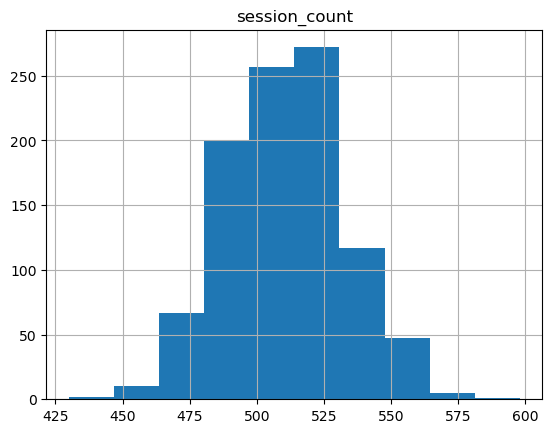

In [15]:
pdf = session_count.toPandas()
pdf.hist(column='session_count')

# 3. Spark ML

## Ключевые понятия

* **Pipeline**  
Организация серии трансформеров и эстиматоров в единый конвейер

* **Estimator**
Алгоримт непосредственно обучения, возвращает модель, которая является трансформером

![](https://spark.apache.org/docs/latest/img/ml-Pipeline.png)

* **Transformer**  
Алгоритм, который трансформирует один датафрейм в другой на основе заданных правил. Это касается как предсказаний, так и фиче-инжиниринга

![](https://spark.apache.org/docs/latest/img/ml-PipelineModel.png)

In [5]:
spark.sparkContext

<SparkContext master=yarn appName=Spark next part>

In [5]:
from pyspark.ml.linalg import Vectors

In [8]:
from pyspark.ml.classification import LogisticRegression

In [7]:
train = spark.createDataFrame([
    (1.0, Vectors.dense([0.0, 1.1, 0.1])),
    (0.0, Vectors.dense([2.0, 1.0, -1.0])),
    (0.0, Vectors.dense([2.0, 1.3, 1.0])),
    (1.0, Vectors.dense([0.0, 1.2, -0.5]))], schema = ["label", "features"])

In [28]:
train.show()

In [10]:
LogisticRegression?

In [11]:
lr = LogisticRegression(maxIter=10, regParam=0.01)

In [12]:
from pyspark.ml import Estimator, Transformer

In [13]:
isinstance(lr, Estimator)

True

In [14]:
type(lr)

pyspark.ml.classification.LogisticRegression

In [15]:
lr.params

[Param(parent='LogisticRegression_9b1e7f27ed0b', name='aggregationDepth', doc='suggested depth for treeAggregate (>= 2).'),
 Param(parent='LogisticRegression_9b1e7f27ed0b', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'),
 Param(parent='LogisticRegression_9b1e7f27ed0b', name='family', doc='The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial'),
 Param(parent='LogisticRegression_9b1e7f27ed0b', name='featuresCol', doc='features column name.'),
 Param(parent='LogisticRegression_9b1e7f27ed0b', name='fitIntercept', doc='whether to fit an intercept term.'),
 Param(parent='LogisticRegression_9b1e7f27ed0b', name='labelCol', doc='label column name.'),
 Param(parent='LogisticRegression_9b1e7f27ed0b', name='lowerBoundsOnCoefficients', doc='The lower bounds on coefficients if fitting under bound cons

In [16]:
lr.getOrDefault("regParam")

0.01

In [17]:
train.rdd.getNumPartitions()

2

In [18]:
model = lr.fit(train)

In [19]:
type(model)

pyspark.ml.classification.LogisticRegressionModel

In [20]:
isinstance(model, Transformer)

True

In [21]:
model.coefficients

DenseVector([-3.1194, 0.9239, -0.2284])

In [22]:
model.interceptVector

DenseVector([2.0352])

In [23]:
predict = model.transform(train)

In [24]:
predict.printSchema()

root
 |-- label: double (nullable = true)
 |-- features: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)



In [25]:
predict.show(10, truncate=False, vertical=True)

-RECORD 0--------------------------------------------------
 label         | 1.0                                       
 features      | [0.0,1.1,0.1]                             
 rawPrediction | [-3.028662373865532,3.028662373865532]    
 probability   | [0.046147671017319175,0.9538523289826808] 
 prediction    | 1.0                                       
-RECORD 1--------------------------------------------------
 label         | 0.0                                       
 features      | [2.0,1.0,-1.0]                            
 rawPrediction | [3.051262081192721,-3.051262081192721]    
 probability   | [0.9548369828995525,0.045163017100447456] 
 prediction    | 0.0                                       
-RECORD 2--------------------------------------------------
 label         | 0.0                                       
 features      | [2.0,1.3,1.0]                             
 rawPrediction | [3.230892374668947,-3.230892374668947]    
 probability   | [0.9619804041934984,0.0

In [26]:
model.getOrDefault("threshold")

0.5

## Токсичные комментарии!

Давайте изучим этот замечательный датасет

Изучите датасет. Давайте загрузим его в DataFrame

In [27]:
!hdfs dfs -head /datasets/toxic/train.csv

"id","comment_text","toxic","severe_toxic","obscene","threat","insult","identity_hate"
"0000997932d777bf","Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0,0,0,0,0,0
"000103f0d9cfb60f","D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)",0,0,0,0,0,0
"000113f07ec002fd","Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0,0,0,0,0,0
"0001b41b1c6bb37e","""
More
I can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents""""  -I think the refere

schema = ...

In [30]:
schema = StructType([
    StructField("id", StringType()),
    StructField("comment_text", StringType()),
    StructField("toxic", IntegerType()),
    StructField("severe_toxic", IntegerType()),
    StructField("obscene", IntegerType()),
    StructField("threat", IntegerType()),
    StructField("insult", IntegerType()),
    StructField("identity_hate", IntegerType())
])

dataset = spark.read.csv...

In [31]:
dataset = spark.read.csv("/datasets/toxic/train.csv", schema=schema, header=True)

In [32]:
dataset.show(2, vertical=True)

-RECORD 0-----------------------------
 id            | 0000997932d777bf     
 comment_text  | Explanation          
 toxic         | null                 
 severe_toxic  | null                 
 obscene       | null                 
 threat        | null                 
 insult        | null                 
 identity_hate | null                 
-RECORD 1-----------------------------
 id            | Why the edits mad... 
 comment_text  |  just closure on ... 
 toxic         | 0                    
 severe_toxic  | 0                    
 obscene       | 0                    
 threat        | 0                    
 insult        | 0                    
 identity_hate | 0                    
only showing top 2 rows



Возможно, надо добавить какие-то опции в чтении csv?

In [41]:
!hdfs dfs -head /datasets/toxic/train.csv

"id","comment_text","toxic","severe_toxic","obscene","threat","insult","identity_hate"
"0000997932d777bf","Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0,0,0,0,0,0
"000103f0d9cfb60f","D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)",0,0,0,0,0,0
"000113f07ec002fd","Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0,0,0,0,0,0
"0001b41b1c6bb37e","""
More
I can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents""""  -I think the refere

In [42]:
spark.read.csv?

In [33]:
dataset = spark.read.csv("/datasets/toxic/train.csv", schema=schema, header=True, multiLine=True)

In [34]:
dataset.show(5, vertical=True)

-RECORD 0-----------------------------
 id            | 0000997932d777bf     
 comment_text  | Explanation\nWhy ... 
 toxic         | 0                    
 severe_toxic  | 0                    
 obscene       | 0                    
 threat        | 0                    
 insult        | 0                    
 identity_hate | 0                    
-RECORD 1-----------------------------
 id            | 000103f0d9cfb60f     
 comment_text  | D'aww! He matches... 
 toxic         | 0                    
 severe_toxic  | 0                    
 obscene       | 0                    
 threat        | 0                    
 insult        | 0                    
 identity_hate | 0                    
-RECORD 2-----------------------------
 id            | 000113f07ec002fd     
 comment_text  | Hey man, I'm real... 
 toxic         | 0                    
 severe_toxic  | 0                    
 obscene       | 0                    
 threat        | 0                    
 insult        | 0       

In [35]:
dataset = spark.read.csv("/datasets/toxic/train.csv", schema=schema, 
                         header=True, multiLine=True, escape='"')

In [36]:
dataset.show(5, vertical=True, truncate=False)

-RECORD 0-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 id            | 0000997932d777bf                                                                                                                                                                                                                                                                                                                                  

In [37]:
dataset.rdd.getNumPartitions()

1

In [38]:
dataset.count()

159571

In [39]:
dataset = dataset.repartition(4).cache()

In [40]:
dataset.count()

159571

## Начнем с бинарной классификации (toxic/non-toxic)

In [41]:
dataset.printSchema()

root
 |-- id: string (nullable = true)
 |-- comment_text: string (nullable = true)
 |-- toxic: integer (nullable = true)
 |-- severe_toxic: integer (nullable = true)
 |-- obscene: integer (nullable = true)
 |-- threat: integer (nullable = true)
 |-- insult: integer (nullable = true)
 |-- identity_hate: integer (nullable = true)



Давайте с помощью команды f.when составим бинарное поле токсичности

In [42]:
f.when?

In [43]:
target = f.when(
    (dataset.toxic == 0) &
    (dataset.severe_toxic == 0) &
    (dataset.obscene == 0) &
    (dataset.threat == 0) &
    (dataset.insult == 0) &
    (dataset.identity_hate == 0),
    0
).otherwise(1)

In [44]:
dataset = dataset.withColumn("target", target)

In [45]:
dataset.select("id", "comment_text", "target").show(10, truncate=False)

+----------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------+
|id              |comment_text                                                                                                                                                                                                                                                                                                                                                                         

In [46]:
targets = dict(dataset.groupBy("target").count().collect())

In [47]:
targets

{1: 16225, 0: 143346}

In [48]:
targets[1] / (targets[0] + targets[1])

0.10167887648758234

In [49]:
dataset = dataset.drop("toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate").cache()

In [50]:
dataset

DataFrame[id: string, comment_text: string, target: int]

In [51]:
dataset.show(2, False, True)

-RECORD 0----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 id           | 6fdb7b6734f8bf40                                                                                                                                                                                                                                                                                                                       
 comment_text | "\n\n""Katara""\nI've removed the section entirely. I don't care if you like to pretend that Katara and Zuko are meant for each other. It's still not case, and there has been no indication whatsoever. Thus, there's little point to actually have the section and exempt Toph and Sokka beyond the in

In [53]:
dataset.write.parquet("/user/kravchenko01/toxic_dataset", mode="overwrite")

In [54]:
dataset.printSchema()

root
 |-- id: string (nullable = true)
 |-- comment_text: string (nullable = true)
 |-- target: integer (nullable = false)



##  Построим простую бинарную логистическую регрессию

In [55]:
from pyspark.ml.feature import *

### Займемся токенами

In [56]:
Tokenizer?

Давайте создадим токенайзер, натравим его на поле с комментариями и создадим с его помощью новый датасет. Если забыли операцию применения, посмотрите в самое начало. раздела

In [57]:
tokenizer = Tokenizer(inputCol="comment_text", outputCol="words")

In [58]:
dataset2 = tokenizer.transform(dataset)

In [59]:
dataset2.select("id", "words").show(2, False, True)

-RECORD 0-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 id    | 6fdb7b6734f8bf40                                                                                                                                                                                                                                                                                                                                                                               
 words | [", , ""katara"", i've, removed, the, section, entirely., i, don't, care, if, you, like, to, pretend, that, katara, and, zuko, are, meant, for, each, other., it's, still, not, case,, and, there, has, been,

### Конвертируем наши слова в вектора с помощью hashing trick
Допустим, количество фичей у нас будет 100. А классификация у нас, напоминаем, бинарная.

In [60]:
HashingTF?

24/04/24 16:53:23 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_106_1 !
24/04/24 16:53:23 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_79_3 !
24/04/24 16:53:23 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_106_3 !
24/04/24 16:53:23 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_79_0 !
24/04/24 16:53:23 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_79_1 !
24/04/24 16:53:23 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_79_2 !
24/04/24 16:53:23 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_106_0 !
24/04/24 16:53:23 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_106_2 !


In [61]:
# моё
# hasher = HashingTF(numFeatures=100, binary=True, inputCol='words', outputCol='hashing_word')

In [62]:
hasher = HashingTF(numFeatures=100, binary=True, inputCol=tokenizer.getOutputCol(), outputCol="word_vector")

In [63]:
dataset2 = hasher.transform(dataset2)

In [64]:
dataset2.select("id", "word_vector").show(2, False, True)

-RECORD 0----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 id          | 6fdb7b6734f8bf40                                                                                                                                                                                                                                                                              
 word_vector | (100,[0,3,4,5,10,12,14,16,17,19,24,30,31,34,35,37,38,41,42,44,47,50,56,60,63,66,68,69,72,74,76,81,85,88,89,90,91,95,96,99],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0]) 
-RECORD 1-------------------------------------------------------------------------------------

24/04/24 17:04:42 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_106_0 !
24/04/24 17:04:42 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_79_0 !


### Настала пора разбить на тест и трейн!
Классы у нас несбалансированные, поэтому надо подкрутить параметры

In [65]:
dataset2.sampleBy?

In [66]:
train = dataset2.sampleBy("target", fractions={0: 0.8, 1: 0.8}, seed=42)

In [67]:
train_targets = dict(train.groupby("target").count().collect())

In [68]:
train_targets

{1: 12962, 0: 114778}

In [69]:
train_targets[1] / (train_targets[0] + train_targets[1])

0.10147173947080006

А как можно с помощью join взять оставшиеся данные?

In [70]:
dataset2.join?

In [71]:
test = dataset2.join(train, on="id", how="leftanti")

In [72]:
test_targets = dict(test.groupby("target").count().collect())

In [73]:
test_targets[1] / (test_targets[0] + test_targets[1])

0.10251013163268512

In [74]:
train.rdd.getNumPartitions()

4

In [75]:
test.rdd.getNumPartitions()

2

In [76]:
train = train.drop("comment_text", "words").cache()

In [77]:
test = test.drop("comment_text", "words").repartition(4).cache()

In [78]:
test.rdd.getNumPartitions()

4

### Настало время для фита!
Двайте начнем с Логистической регрессии. Ограничимся 15 итерациями, чтобы не усложнять себе жизнь

In [80]:
from pyspark.ml.classification import LogisticRegression

In [81]:
LogisticRegression?

In [82]:
# ваш код здесь
lr = LogisticRegression(featuresCol=hasher.getOutputCol(), labelCol="target", maxIter=15)

Зафитим!

In [83]:
# ваш код здесь
lr_model = lr.fit(train)

In [84]:
lr_model?

Запредиктим!

In [86]:
# ваш код здесь
predictions = lr_model.transform(test)

In [87]:
predictions.printSchema()

root
 |-- id: string (nullable = true)
 |-- target: integer (nullable = false)
 |-- word_vector: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)



In [88]:
predictions.select("id", "target", "prediction", "probability", "rawPrediction").show(10, False, True)

-RECORD 0--------------------------------------------------
 id            | 19c241834dc5b8c3                          
 target        | 0                                         
 prediction    | 0.0                                       
 probability   | [0.9857870565423278,0.014212943457672211] 
 rawPrediction | [4.239287303745873,-4.239287303745873]    
-RECORD 1--------------------------------------------------
 id            | a046697fb2ccc104                          
 target        | 1                                         
 prediction    | 0.0                                       
 probability   | [0.7518910714806264,0.2481089285193736]   
 rawPrediction | [1.1087235840699812,-1.1087235840699812]  
-RECORD 2--------------------------------------------------
 id            | b14b26bc6d5dce94                          
 target        | 0                                         
 prediction    | 0.0                                       
 probability   | [0.8848918856165426,0.1

А как Accuracy посчитать?

In [94]:
# ваш код здесь
true_predictions = predictions.select("target", f.col("prediction").cast("int")).filter("target == prediction").count()

In [95]:
print("Accuracy is {}".format(true_predictions / predictions.count()))

Accuracy is 0.8999088938456222


### Это хорошо? Может быть...

In [96]:
predictions.select("target", f.col("prediction").cast("int"))\
           .filter((f.col("target") == 1) & (f.col("prediction") == f.col("target")))\
           .count()

182

In [97]:
predictions.printSchema()

root
 |-- id: string (nullable = true)
 |-- target: integer (nullable = false)
 |-- word_vector: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)



In [98]:
predictions_pd = predictions.select("target", f.col("prediction").cast("int")).toPandas()

In [99]:
predictions_pd.head()

,target,prediction
0,0,0
1,1,0
2,0,0
3,1,0
4,1,0


In [100]:
lr.getOrDefault("threshold")

0.5

In [101]:
from sklearn.metrics import classification_report, precision_score

In [102]:
print(classification_report(predictions_pd.target, predictions_pd.prediction))

              precision    recall  f1-score   support

           0       0.90      1.00      0.95     28568
           1       0.63      0.06      0.10      3263

    accuracy                           0.90     31831
   macro avg       0.77      0.53      0.52     31831
weighted avg       0.87      0.90      0.86     31831



In [103]:
train.count()

127740

### А если хочется что-то посложнее?

In [104]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [105]:
BinaryClassificationEvaluator?

In [106]:
evaluator = BinaryClassificationEvaluator(labelCol="target", metricName='areaUnderROC')

In [107]:
evaluator.evaluate(predictions)

0.7723084998823826

In [108]:
evaluator.setParams(metricName="precision")

BinaryClassificationEvaluator_10f649d7ab96

In [109]:
evaluator.evaluate(predictions)

IllegalArgumentException: BinaryClassificationEvaluator_10f649d7ab96 parameter metricName given invalid value precision.

## Упс :(

`spark.ml.evaluation.BinaryClassificationEvaluator` supports only ROC AUC and PR AUC.

## Так а если хотим больше?
Давайте посчитаем метрику Accuracy через эвалуатор!

In [110]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [111]:
MulticlassClassificationEvaluator?

In [112]:
# ваш код здесь
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="target", metricName='accuracy')

In [113]:
evaluator.evaluate(predictions)

0.8999088938456222

А если weightedPrecision или weightedRecall?

In [ ]:
evaluator?

In [116]:
# ваш код здесь
evaluator.setMetricName("weightedPrecision")

MulticlassClassificationEvaluator_426b10e29b35

In [117]:
evaluator.evaluate(predictions)

0.8748356832227001

In [118]:
# ваш код здесь
evaluator.setMetricName("weightedRecall")

MulticlassClassificationEvaluator_426b10e29b35

In [119]:
evaluator.evaluate(predictions)

0.8999088938456222

### А теперь все вместе!

In [121]:
dataset = spark.read.parquet("/user/kravchenko01/toxic_dataset")

In [123]:
!hdfs dfs -ls /user/kravchenko01/toxic_dataset

Found 5 items
-rw-r--r--   3 kravchenko01 kravchenko01          0 2024-04-24 16:40 /user/kravchenko01/toxic_dataset/_SUCCESS
-rw-r--r--   3 kravchenko01 kravchenko01   10811862 2024-04-24 16:40 /user/kravchenko01/toxic_dataset/part-00000-6b0d8a56-204f-4144-b55b-0d903993d7cf-c000.snappy.parquet
-rw-r--r--   3 kravchenko01 kravchenko01   10788072 2024-04-24 16:40 /user/kravchenko01/toxic_dataset/part-00001-6b0d8a56-204f-4144-b55b-0d903993d7cf-c000.snappy.parquet
-rw-r--r--   3 kravchenko01 kravchenko01   10753895 2024-04-24 16:40 /user/kravchenko01/toxic_dataset/part-00002-6b0d8a56-204f-4144-b55b-0d903993d7cf-c000.snappy.parquet
-rw-r--r--   3 kravchenko01 kravchenko01   10731298 2024-04-24 16:40 /user/kravchenko01/toxic_dataset/part-00003-6b0d8a56-204f-4144-b55b-0d903993d7cf-c000.snappy.parquet


In [124]:
dataset

DataFrame[id: string, comment_text: string, target: int]

In [125]:
dataset.rdd.getNumPartitions()

2

In [126]:
from pyspark.ml import Pipeline

Соберем пайплайн!

In [127]:
Pipeline?

In [129]:
# ваш код здесь
pipeline = Pipeline(stages=[
    tokenizer,
    hasher,
    lr,
])

Снова разбиваем на трейн и тест... А как?

In [ ]:
# ваш код здесь

In [128]:
# ваш код здесь
train = dataset.sampleBy("target", fractions={0: 0.8, 1: 0.8}).cache()
test = dataset.join(train, on="id", how="leftanti").cache()

Фит!

In [131]:
# ваш код здесь
pipeline_model = pipeline.fit(train)

Предикт!

In [132]:
# ваш код здесь
predictions = pipeline_model.transform(test)

Эвалуатор на ваш вкус

In [133]:
# ваш код здесь
evaluator = MulticlassClassificationEvaluator(labelCol="target", metricName="weightedRecall")

In [135]:
# ваш код здесь
evaluator.evaluate(predictions)

0.8986945664886051

### Так, а есть что-то позаковыристее?

In [136]:
from pyspark.ml.classification import GBTClassifier

In [137]:
GBTClassifier?

In [138]:
gbt = GBTClassifier(featuresCol=hasher.getOutputCol(), labelCol="target", maxIter=20, maxDepth=3)

Добавим в пайплайн

In [139]:
# ваш код здесь
pipeline = Pipeline(stages=[
    tokenizer,
    hasher,
    gbt,
])

Фит, предикт, проверка

In [142]:
# ваш код здесь
pipeline_model = pipeline.fit(train)

24/04/24 20:19:37 ERROR ContextCleaner: Error cleaning shuffle 101
java.lang.NullPointerException
	at org.apache.spark.MapOutputTrackerMaster.$anonfun$unregisterShuffle$1(MapOutputTracker.scala:882)
	at org.apache.spark.MapOutputTrackerMaster.$anonfun$unregisterShuffle$1$adapted(MapOutputTracker.scala:881)
	at scala.Option.foreach(Option.scala:437)
	at org.apache.spark.MapOutputTrackerMaster.unregisterShuffle(MapOutputTracker.scala:881)
	at org.apache.spark.ContextCleaner.doCleanupShuffle(ContextCleaner.scala:241)
	at org.apache.spark.ContextCleaner.$anonfun$keepCleaning$3(ContextCleaner.scala:202)
	at org.apache.spark.ContextCleaner.$anonfun$keepCleaning$3$adapted(ContextCleaner.scala:195)
	at scala.Option.foreach(Option.scala:437)
	at org.apache.spark.ContextCleaner.$anonfun$keepCleaning$1(ContextCleaner.scala:195)
	at org.apache.spark.util.Utils$.tryOrStopSparkContext(Utils.scala:1446)
	at org.apache.spark.ContextCleaner.org$apache$spark$ContextCleaner$$keepCleaning(ContextCleaner.s

In [143]:
# ваш код здесь
predictions = pipeline_model.transform(test)

In [144]:
# ваш код здесь
evaluator.evaluate(predictions)

0.8970193128299143

### Добавим степеней свободы
Допустим, хотим добавить в хэши 1000 фичей. А как?

In [145]:
pipeline_model.stages

[Tokenizer_9def539967fc,
 HashingTF_4e7a6642b1f1,
 GBTClassificationModel: uid = GBTClassifier_a3c836dafe3b, numTrees=20, numClasses=2, numFeatures=100]

In [ ]:
pipeline.fit?

In [146]:
# ваш код здесь
pipeline_model = pipeline.fit(train, params={hasher.numFeatures: 1000})

In [147]:
pipeline_model.stages[1].extractParamMap()

{Param(parent='HashingTF_4e7a6642b1f1', name='binary', doc='If True, all non zero counts are set to 1. This is useful for discrete probabilistic models that model binary events rather than integer counts. Default False.'): True,
 Param(parent='HashingTF_4e7a6642b1f1', name='numFeatures', doc='Number of features. Should be greater than 0.'): 1000,
 Param(parent='HashingTF_4e7a6642b1f1', name='outputCol', doc='output column name.'): 'word_vector',
 Param(parent='HashingTF_4e7a6642b1f1', name='inputCol', doc='input column name.'): 'words'}

In [148]:
predictions = pipeline_model.transform(test)

In [149]:
evaluator.evaluate(predictions)

0.9083667857255745

### Почистим от стопслов

In [150]:
StopWordsRemover?

In [151]:
stop_words = StopWordsRemover.loadDefaultStopWords("english")

In [152]:
stop_words

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 'her',
 'hers',
 'herself',
 'it',
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each',
 'few',
 'more',
 'most',
 'other',
 'some',
 'such',
 'no',
 'nor',
 '

In [153]:
swr = StopWordsRemover(inputCol=tokenizer.getOutputCol(), outputCol="words_filtered", 
                       stopWords=stop_words)

In [154]:
hasher = HashingTF(numFeatures=1000, binary=True, inputCol=swr.getOutputCol(), 
                   outputCol="word_vector")

А как изменится пайплайн?

In [155]:
# ваш код здесь
pipeline = Pipeline(stages=[
    tokenizer,
    swr,
    hasher,
    lr,
])

In [156]:
pipeline_model = pipeline.fit(train)

24/04/24 20:30:38 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/04/24 20:30:38 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
24/04/24 20:30:38 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
24/04/24 20:30:38 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


In [157]:
pipeline_model.stages

[Tokenizer_9def539967fc,
 StopWordsRemover_2f5f2e49795d,
 HashingTF_336827448802,
 LogisticRegressionModel: uid=LogisticRegression_26cec285a90a, numClasses=2, numFeatures=1000]

In [158]:
predictions = pipeline_model.transform(test)

In [159]:
evaluator.evaluate(predictions)

0.9152890602775231

### Даешь еще фичей!

In [160]:
import pyspark.sql.functions as f

In [161]:
dataset.printSchema()

root
 |-- id: string (nullable = true)
 |-- comment_text: string (nullable = true)
 |-- target: integer (nullable = true)



Давайте добавил длину коментария?

In [163]:
# ваш код здесь
dataset = dataset.withColumn("comment_length", f.length(dataset.comment_text))

In [164]:
dataset.show()

+----------------+--------------------+------+--------------+
|              id|        comment_text|target|comment_length|
+----------------+--------------------+------+--------------+
|6fdb7b6734f8bf40|"\n\n""Katara""\n...|     0|           323|
|26e1b63617df36b1|"\n\n charlie wil...|     0|           242|
|85e4f353ca4b2bde|Arthur Rose Eldre...|     0|           581|
|9d2196265213dce8|Re: Help translat...|     0|           110|
|fb7a63a8e287b2d1|Sources for Gambi...|     0|           568|
|fd42fd6a1ea341c4|Just let me hear ...|     0|           130|
|54f9e59924682c6e|Flamboyant (gay) ...|     0|           197|
|01c0ae884d69319b|Thank you \n\nI j...|     0|            36|
|f7fec98d6aac8ce3|Removed the notab...|     0|            32|
|25553d990b245467|I AM HAVING MY PE...|     1|            22|
|0f5c123acb6ba9be|Hello. Why do you...|     0|           114|
|901d7783bca3d63f|Use one that does...|     1|            52|
|7b65f1b25caab0cc|Movie removal fro...|     0|           241|
|09201fc

In [165]:
train = dataset.sampleBy("target", fractions={0: 0.8, 1: 0.8}).cache()
test = dataset.join(train, on="id", how="leftanti").cache()

### Не забываем, что фичи должны быть в одной колонке. `VectorAssembler` нам поможем!

In [166]:
assembler = VectorAssembler(inputCols=[hasher.getOutputCol(), "comment_length"], outputCol="features")

In [167]:
lr = LogisticRegression(labelCol="target", maxIter=15)

In [168]:
pipeline = Pipeline(stages=[
    tokenizer,
    swr,
    hasher,
    assembler,
    lr
])

In [169]:
pipeline_model = pipeline.fit(train)

In [170]:
pipeline_model.stages

[Tokenizer_9def539967fc,
 StopWordsRemover_2f5f2e49795d,
 HashingTF_336827448802,
 VectorAssembler_fe9897a74162,
 LogisticRegressionModel: uid=LogisticRegression_fccb41b1188e, numClasses=2, numFeatures=1001]

In [171]:
predictions = pipeline_model.transform(test)

In [172]:
evaluator.evaluate(predictions)

0.9163822525597269

In [173]:
pipeline_model.stages[-1].coefficients[-1]

0.0006948000928140583

### А что там вообще другие придумали? 
https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/discussion/52557

In [174]:
CountVectorizer?

А что с ним надо сделать? Надо ли поменять какие-то параметры в пайплайне или даже элементы?

In [175]:
# ваш код здесь
count_vectorizer = CountVectorizer(inputCol=swr.getOutputCol(), outputCol="word_vector", binary=True)

In [176]:
# ваш код здесь
assembler = VectorAssembler(inputCols=[count_vectorizer.getOutputCol(), "comment_length"], outputCol="features")

In [177]:
# ваш код здесь
pipeline = Pipeline(stages=[
    tokenizer,
    swr,
    count_vectorizer,
    assembler,
    lr
])

In [178]:
pipeline_model = pipeline.fit(train)

24/04/24 20:43:32 WARN DAGScheduler: Broadcasting large task binary with size 18.6 MiB


24/04/24 20:43:41 WARN DAGScheduler: Broadcasting large task binary with size 18.6 MiB


24/04/24 20:43:46 WARN DAGScheduler: Broadcasting large task binary with size 18.6 MiB


24/04/24 20:43:47 WARN DAGScheduler: Broadcasting large task binary with size 18.6 MiB


24/04/24 20:43:49 WARN DAGScheduler: Broadcasting large task binary with size 18.6 MiB


24/04/24 20:43:50 WARN DAGScheduler: Broadcasting large task binary with size 18.6 MiB


24/04/24 20:43:52 WARN DAGScheduler: Broadcasting large task binary with size 18.6 MiB


24/04/24 20:43:54 WARN DAGScheduler: Broadcasting large task binary with size 18.6 MiB


24/04/24 20:43:56 WARN DAGScheduler: Broadcasting large task binary with size 18.6 MiB


24/04/24 20:43:57 WARN DAGScheduler: Broadcasting large task binary with size 18.6 MiB


24/04/24 20:43:59 WARN DAGScheduler: Broadcasting large task binary with size 18.6 MiB


24/04/24 20:44:00 WARN DAGScheduler: Broadcasting large task binary with size 18.6 MiB


24/04/24 20:44:03 WARN DAGScheduler: Broadcasting large task binary with size 18.6 MiB


24/04/24 20:44:04 WARN DAGScheduler: Broadcasting large task binary with size 18.6 MiB


24/04/24 20:44:05 WARN DAGScheduler: Broadcasting large task binary with size 18.6 MiB


24/04/24 20:44:07 WARN DAGScheduler: Broadcasting large task binary with size 18.6 MiB


24/04/24 20:44:08 WARN DAGScheduler: Broadcasting large task binary with size 18.6 MiB


24/04/24 20:44:10 WARN DAGScheduler: Broadcasting large task binary with size 18.6 MiB


In [179]:
predictions = pipeline_model.transform(test)

In [180]:
evaluator.evaluate(predictions)

24/04/24 20:44:36 WARN DAGScheduler: Broadcasting large task binary with size 20.7 MiB


0.925673113386424

### Что ж это за ML да без тюнинга гиперпаметров?

In [181]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [182]:
ParamGridBuilder?

24/04/24 20:55:44 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_1693_58 !
24/04/24 20:55:44 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_493_34 !
24/04/24 20:55:44 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_1693_98 !
24/04/24 20:55:44 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_493_42 !
24/04/24 20:55:44 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_493_25 !
24/04/24 20:55:44 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_1693_67 !
24/04/24 20:55:44 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_1693_183 !
24/04/24 20:55:44 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_204_0 !
24/04/24 20:55:44 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_493_48 !
24/04/24 20:55:44 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_1693_120 !
24/04/24 20:55:44 WARN BlockManagerMasterEnd

In [ ]:
paramGrid = ParamGridBuilder().addGrid(count_vectorizer.vocabSize, [100, 500])\
                              .addGrid(lr.regParam, [0.01, 0.05])\
                              .build()

In [ ]:
paramGrid

In [ ]:
crossval = CrossValidator(estimator=pipeline, estimatorParamMaps=paramGrid,
                          evaluator=evaluator, numFolds=3, parallelism=4)

In [ ]:
cv_model = crossval.fit(train)

In [ ]:
cv_model.avgMetrics

In [ ]:
cv_model.bestModel

In [ ]:
predictions = cv_model.transform(test)

In [ ]:
evaluator.evaluate(predictions)

## А если я хочу больше разных моделей?

### 1. Обучим случайный лес локально

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

In [ ]:
X, y = make_classification(random_state=42)

In [ ]:
y.shape

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape

In [ ]:
est = LogisticRegression(random_state=42)

In [ ]:
est.fit(X_train, y_train)

### 2. Теперь уложим это в Spark

In [ ]:
from pyspark.ml.linalg import DenseVector
from pyspark.ml.linalg import VectorUDT

#### Spark требует немного другой формат. Сконвертируем

In [ ]:
schema = StructType(fields=[
    StructField("features", VectorUDT()),
    StructField("label", IntegerType())
])

In [ ]:
df_test = spark.createDataFrame(zip(map(DenseVector, X_test), map(int, y_test)), schema=schema)

In [ ]:
df_test.show()

#### Приправим магией pandas_udf

In [ ]:
est_broadcast = spark.sparkContext.broadcast(est)

In [ ]:
import pandas as pd

In [ ]:
@f.pandas_udf(FloatType())
def predict(features):
    predictions = est_broadcast.value.predict(features)
    return pd.Series(predictions)

In [ ]:
df_test.withColumn("prediction", predict("features")).show()

#### Ой, в PyArrow нет векторов :(

In [ ]:
from pyspark.ml.functions import vector_to_array

In [ ]:
df_test.withColumn("prediction", predict(vector_to_array("features"))).show()

#### Продолжаем обрабатывать напильником

In [ ]:
@f.pandas_udf(FloatType())
def predict(series):
    predictions = est_broadcast.value.predict(series.tolist())
    return pd.Series(predictions)

In [ ]:
df_test.withColumn("prediction", predict(vector_to_array("features"))).show()

In [183]:
spark.stop()

# Домашка!

In [4]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import *

from pyspark.sql.types import *
import pyspark.sql.functions as f

In [5]:
!hdfs dfs -head /datasets/amazon/train.json

{"id":1,"overall":2,"vote":null,"verified":false,"reviewTime":"12 5, 2015","reviewerID":"A3KUPJ396OQF78","asin":"B017O9P72A","reviewerName":"Larry Russlin","reviewText":"Can only control one of two bulbs from one of two echos","summary":"Buggy","unixReviewTime":1449273600}
{"id":2,"overall":5,"vote":null,"verified":false,"reviewTime":"01 15, 2018","reviewerID":"A3TXR8GLKS19RE","asin":"B017O9P72A","reviewerName":"Nello","reviewText":"Great skill","summary":"Great","unixReviewTime":1515974400}
{"id":3,"overall":1,"vote":"2","verified":false,"reviewTime":"01 4, 2018","reviewerID":"A1FOHYK23FJ6CN","asin":"B017O9P72A","reviewerName":"L. Ray Humphreys","reviewText":"Not happy. Can not connect to Alexa regardless.","summary":"Can not connect to ECHO","unixReviewTime":1515024000}
{"id":4,"overall":1,"vote":"5","verified":false,"reviewTime":"12 30, 2017","reviewerID":"A1RRDX9AOST1AN","asin":"B017O9P72A","reviewerName":"Viola","reviewText":"Can not connect a hue lights to Alexa. Linked the LIFX 

In [67]:
# schema = StructType(fields=[
#     StructField("id", IntegerType()),
#     StructField("overall", FloatType()),
#     StructField("vote", StringType()),
#     StructField("verified", BooleanType()),
#     StructField("reviewTime", StringType()),
#     StructField("reviewerID", StringType()),
#     StructField("asin", StringType()),
#     StructField("reviewerName", StringType()),
#     StructField("reviewText", StringType()),
#     StructField("summary", StringType()),
#     StructField("unixReviewTime", LongType()),
# ])

In [7]:
spark.read.json?

In [65]:
data_path = "/datasets/amazon/train.json"

train_data = spark.read.json(data_path)

In [66]:
train_data.printSchema()

root
 |-- asin: string (nullable = true)
 |-- id: long (nullable = true)
 |-- overall: long (nullable = true)
 |-- reviewText: string (nullable = true)
 |-- reviewTime: string (nullable = true)
 |-- reviewerID: string (nullable = true)
 |-- reviewerName: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- unixReviewTime: long (nullable = true)
 |-- verified: boolean (nullable = true)
 |-- vote: string (nullable = true)



In [42]:
train_data.show(5)

+---+-------+----+--------+-----------+--------------+----------+----------------+--------------------+--------------------+--------------+
| id|overall|vote|verified| reviewTime|    reviewerID|      asin|    reviewerName|          reviewText|             summary|unixReviewTime|
+---+-------+----+--------+-----------+--------------+----------+----------------+--------------------+--------------------+--------------+
|  1|    2.0|null|   false| 12 5, 2015|A3KUPJ396OQF78|B017O9P72A|   Larry Russlin|Can only control ...|               Buggy|    1449273600|
|  2|    5.0|null|   false|01 15, 2018|A3TXR8GLKS19RE|B017O9P72A|           Nello|         Great skill|               Great|    1515974400|
|  3|    1.0|   2|   false| 01 4, 2018|A1FOHYK23FJ6CN|B017O9P72A|L. Ray Humphreys|Not happy. Can no...|Can not connect t...|    1515024000|
|  4|    1.0|   5|   false|12 30, 2017|A1RRDX9AOST1AN|B017O9P72A|           Viola|Can not connect a...|Connecting is a n...|    1514592000|
|  5|    1.0|   5|  

In [69]:
train_data = train_data.fillna("null", subset=("reviewText", "summary", "vote")).cache()
                        #.withColumn("vote", train_data["vote"].cast(IntegerType()))\
#                        .fillna(0, subset="vote")\


In [70]:
sample_data = train_data.sample(False, 0.1, seed=0)

In [23]:
LinearRegression?

In [74]:
lr = LinearRegression(featuresCol="features", labelCol="overall", maxIter=1, regParam=0.1)

In [72]:
tokenizer1 = Tokenizer(inputCol="reviewText", outputCol="reviewText_words")
tokenizer2 = Tokenizer(inputCol="summary", outputCol="summary_words")
tokenizer3 = Tokenizer(inputCol="vote", outputCol="vote_words")

stop_words = StopWordsRemover.loadDefaultStopWords("english")
swr1 = StopWordsRemover(inputCol=tokenizer1.getOutputCol(), outputCol="reviewText_words_filtered", stopWords=stop_words)
swr2 = StopWordsRemover(inputCol=tokenizer2.getOutputCol(), outputCol="summary_words_filtered", stopWords=stop_words)

count_vectorizer1 = CountVectorizer(inputCol=swr1.getOutputCol(), outputCol="word_vector1")
count_vectorizer2 = CountVectorizer(inputCol=swr2.getOutputCol(), outputCol="word_vector2")

# hasher1 = HashingTF(numFeatures=100, inputCol=swr1.getOutputCol(), outputCol="word_vector1")
# hasher2 = HashingTF(numFeatures=100, inputCol=swr2.getOutputCol(), outputCol="word_vector2")
hasher3 = HashingTF(numFeatures=1, inputCol=tokenizer3.getOutputCol(), outputCol="vote_vector")


assembler = VectorAssembler(inputCols=[
    count_vectorizer1.getOutputCol(),
    count_vectorizer2.getOutputCol(),
    hasher3.getOutputCol(),
#     "vote",
    "verified"
],outputCol="features", handleInvalid="keep")

In [31]:
sample_data.where(f.col("reviewText").isNull() & f.col("summary").isNull()).show(5)

+---+-------+----+--------+----------+----------+----+------------+----------+-------+--------------+
| id|overall|vote|verified|reviewTime|reviewerID|asin|reviewerName|reviewText|summary|unixReviewTime|
+---+-------+----+--------+----------+----------+----+------------+----------+-------+--------------+
+---+-------+----+--------+----------+----------+----+------------+----------+-------+--------------+



In [35]:
m = lr.fit(assembler.transform(hasher1.transform(swr1.transform(tokenizer1.transform(sample_data)))))

24/04/26 11:47:26 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/04/26 11:47:26 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


24/04/26 11:47:26 WARN InstanceBuilder$NativeLAPACK: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


In [75]:
pipeline = Pipeline(stages=[
    tokenizer1,
    tokenizer2,
    tokenizer3,
    swr1,
    swr2,
    count_vectorizer1,
    count_vectorizer2,
#     hasher1,
#     hasher2,
    hasher3,
    assembler,
    lr
])

In [76]:
pipeline_model = pipeline.fit(sample_data)

24/04/26 14:01:10 WARN DAGScheduler: Broadcasting large task binary with size 31.4 MiB


24/04/26 14:04:26 WARN DAGScheduler: Broadcasting large task binary with size 31.4 MiB


24/04/26 14:04:48 WARN DAGScheduler: Broadcasting large task binary with size 31.4 MiB


24/04/26 14:07:48 WARN DAGScheduler: Broadcasting large task binary with size 31.4 MiB


24/04/26 14:08:07 WARN DAGScheduler: Broadcasting large task binary with size 31.4 MiB


24/04/26 14:09:24 WARN DAGScheduler: Broadcasting large task binary with size 31.4 MiB


24/04/26 14:09:43 WARN DAGScheduler: Broadcasting large task binary with size 31.4 MiB


24/04/26 14:11:05 WARN DAGScheduler: Broadcasting large task binary with size 31.4 MiB


24/04/26 14:11:24 WARN DAGScheduler: Broadcasting large task binary with size 34.8 MiB


24/04/26 14:14:23 WARN DAGScheduler: Broadcasting large task binary with size 34.8 MiB


In [77]:
predictions = pipeline_model.transform(sample_data)

In [78]:
evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="overall", metricName='rmse')

In [79]:
evaluator.evaluate(predictions)

24/04/26 14:19:10 WARN DAGScheduler: Broadcasting large task binary with size 34.8 MiB


24/04/26 14:22:12 WARN DAGScheduler: Broadcasting large task binary with size 34.8 MiB


1.138095094929562

24/04/26 14:32:21 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_315_8 !
24/04/26 14:32:21 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_315_42 !
24/04/26 14:32:21 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_315_54 !
24/04/26 14:32:21 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_315_6 !
24/04/26 14:32:21 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_315_10 !
24/04/26 14:32:21 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_315_0 !
24/04/26 14:32:21 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_315_30 !
24/04/26 14:32:21 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_315_4 !
24/04/26 14:32:21 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_315_60 !
24/04/26 14:32:21 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_315_12 !
24/04/26 14:32:21 WARN BlockManagerMasterEndpoint: No 

In [80]:
type(predictions)

pyspark.sql.dataframe.DataFrame

In [109]:
spark.stop()

# Dataframes, UI, Tuning

## Оптимизации Spark

### А какие у нас есть еще опции?
[Очень много](https://spark.apache.org/docs/3.3.0/configuration.html)

In [ ]:
import pyspark

In [ ]:
for p in sorted(conf.getAll(), key=lambda p: p[0]):
    print(p)

In [ ]:
for p in sorted(spark.sparkContext.getConf().getAll(), key=lambda p: p[0]):
    print(p)

In [ ]:
conf = SparkConf()
conf.set('spark.ui.port', '14099')
conf.set('spark.driver.memory', '2G')
conf.set('spark.executor.memory', '2G')

spark = SparkSession.builder.config(conf=conf).appName("spark_andrei").getOrCreate()

### Кривые данные

In [ ]:
data = """{"a": 1, "b":2, "c":3}|{"a": 1, "b":2, "c":3}|{"a": 1, "b, "c":10}""".split('|')

In [ ]:
data

In [ ]:
corruptDF = (spark.read
  .option("mode", "PERMISSIVE")
  .option("columnNameOfCorruptRecord", "_corrupt_record")
  .json(spark.sparkContext.parallelize(data))
)
corruptDF.show()

На клетке выше Спарк обработал испорченные данные и поместил их в специальную колонку, остальное успешно обработал.
Это поведение по умолчаниб, мы ничего не применяли опции `mode` и `columnNameOfCorruptRecord`.

Есть три варианта обработки испорченных записей через опцию [`ParseMode`](https://github.com/apache/spark/blob/master/sql/catalyst/src/main/scala/org/apache/spark/sql/catalyst/util/ParseMode.scala#L34):

| `ParseMode` | Поведение |
|-------------|----------|
| `PERMISSIVE` | Складывает все испорченные записии в специальную колонку "_corrupt_record" (по умолчанию) |
| `DROPMALFORMED` | Игнорирует все испорченные записи |
| `FAILFAST` | Выкидывает исключение на первой же неправильной записи |

Следующая клетка уже выкидывает испорченные данные:

In [ ]:
corruptDF = (spark.read
  .option("mode", "DROPMALFORMED")
  .json(spark.sparkContext.parallelize(data))
)
corruptDF.show()

### Кэширование
Какие вообще у нас опции?


* `DataFrame.persist(..)`

In [ ]:
pyspark.sql.DataFrame.persist?

In [ ]:
pyspark.storagelevel.StorageLevel?

In [ ]:
log.count()

In [ ]:
log.cache()

In [ ]:
%%time
log.count()

In [ ]:
log.unpersist()

In [ ]:
spark.catalog.clearCache()

### Spark UI
* Список запланированнных, исполняемых и исполненных этапов (stages) и задач (tasks)
* Информация о размере RDD и использовании памяти
* Информация об окружении
* Информация об экзекуторах
* Все задачи Spark SQL

## Apache Spark RDD

### Что такое RDD?
Resilient Distributed Dataset, основа основ Apache Spark, низкоуровненая базовая абстракция, в которую превратится ваш код на DataFrame API

Из чего состоит RDD
* Dependencies
* Partitions
* Functions
* (если определен) Partitioner
* (если определен) Locations

Transformations и Actions точно так же работают и в RDD!

### Зачем использовать RDD?
* Нужен функционал, которого не оказалось в датафреймах 
* У вас есть старая кодовая база с RDD
* Вам нужен контроль за данными и за распределенными переменными
* Вы хотите добиться высокой производительности (**не в Python!**)

In [ ]:
spark.range(10).rdd

In [ ]:
spark.range(10).toDF("id").rdd.map(lambda row: row[0])

Всегда можно конвертировать туда и обратно!

In [ ]:
spark.range(10).rdd.toDF()

In [ ]:
myCollection = "Big Data and Data Engineering for AI Masters"\
.split(" ")
words = spark.sparkContext.parallelize(myCollection, 2)

In [ ]:
words

In [ ]:
words.setName("bigdata")

In [ ]:
words.name()

#### Transformations

In [ ]:
# distinct
words.distinct().count()

In [ ]:
# filter
def startsWithD(word):
    return word.startswith("D")

In [ ]:
words.filter(lambda word: startsWithD(word)).collect()

In [ ]:
# map
words2 = words.map(lambda word: (word, word[0], word.startswith("D")))

In [ ]:
words2.filter(lambda record: record[2]).take(5)

In [ ]:
# flatMap
words.flatMap(lambda word: list(word)).take(7)

In [ ]:
# sort
words.sortBy(lambda word: len(word) * -1).take(2)

In [ ]:
# Random Splits

In [ ]:
fiftyFiftySplit = words.randomSplit([0.5, 0.5])

In [ ]:
fiftyFiftySplit[0].collect()

In [ ]:
fiftyFiftySplit[1].collect()

#### Actions

In [ ]:
# reduce
spark.sparkContext.parallelize(range(1, 21)).reduce(lambda x, y: x + y)

In [ ]:
def wordLengthReducer(leftWord, rightWord):
    if len(leftWord) > len(rightWord):
        return leftWord
    else:
        return rightWord

In [ ]:
words.reduce(wordLengthReducer)

In [ ]:
# count
words.count()

In [ ]:
# countApprox
confidence = 0.95
timeoutMilliseconds = 100
words.countApprox(timeoutMilliseconds, confidence)

In [ ]:
words.countApprox?

In [ ]:
# countApproxDistinct
words.countApproxDistinct(0.05)

In [ ]:
words.countApproxDistinct?

In [ ]:
# countByValue
words.countByValue()

In [ ]:
# first
words.first()

In [ ]:
# max and min
spark.sparkContext.parallelize(range(1,20)).max()

In [ ]:
spark.sparkContext.parallelize(range(1,20)).min()

In [ ]:
# take
words.take(5)

In [ ]:
words.takeOrdered(5)

In [ ]:
words.top(5)

In [ ]:
words.takeSample(True, 10, 42)

In [ ]:
words.takeSample?

#### Caching

In [ ]:
words.cache()

In [ ]:
words.getStorageLevel()

In [ ]:
# сheckpointing
spark.sparkContext.setCheckpointDir("/tmp/rdd_checkpoint")

In [ ]:
words.checkpoint()

In [ ]:
#piping
words.pipe("wc -l").collect()

In [ ]:
words.getNumPartitions()

In [ ]:
# mapPartitions
words.mapPartitions(lambda part: [1]).sum()

In [ ]:
def indexedFunc(partitionIndex, withinPartIterator):
    return ["partition: {} => {}".format(partitionIndex, x) for x in withinPartIterator]
words.mapPartitionsWithIndex(indexedFunc).collect()

#### Key-Value RDDs
Многие методы подразумевают K-V структуру для выполнения.  
Эта группа выглядит как **"что-то"ByKey**

In [ ]:
# keyBy
keyword = words.keyBy(lambda word: word.lower()[0])

In [ ]:
keyword.take(5)

In [ ]:
# Mapping over Values
keyword.mapValues(lambda word: word.upper()).collect()

In [ ]:
#flatMap
keyword.flatMapValues(lambda word: word.upper()).collect()

In [ ]:
# Извлекаем K-V
keyword.keys().collect()

In [ ]:
keyword.values().collect()

In [ ]:
# lookup
keyword.lookup("d")

In [ ]:
# sampleByKey
import random
distinctChars = words.flatMap(lambda word: list(word.lower())).distinct()\
.collect()
sampleMap = dict(map(lambda c: (c, random.random()), distinctChars))
words.map(lambda word: (word.lower()[0], word))\
.sampleByKey(True, sampleMap, 6).collect()

#### Aggregations

In [ ]:
chars = words.flatMap(lambda word: word.lower())
KVcharacters = chars.map(lambda letter: (letter, 1))
def maxFunc(left, right):
    return max(left, right)
def addFunc(left, right):
    return left + right
nums = spark.sparkContext.parallelize(range(1,31), 5)

In [ ]:
# countByKey
KVcharacters.countByKey()

In [ ]:
# groupByKey
from functools import reduce
KVcharacters.groupByKey().map(lambda row: (row[0], reduce(addFunc, row[1])))\
.collect()

In [ ]:
# reduceByKey
KVcharacters.reduceByKey(addFunc).collect()

In [ ]:
# aggregate
nums.aggregate(0, maxFunc, addFunc)

In [ ]:
#treeAggregate
depth = 3
nums.treeAggregate(0, maxFunc, addFunc, depth)

In [ ]:
nums.treeAggregate?

In [ ]:
# aggregateByKey
KVcharacters.aggregateByKey(0, addFunc, maxFunc).collect()

In [ ]:
# combineByKey
def valToCombiner(value):
    return [value]
def mergeValuesFunc(vals, valToAppend):
    vals.append(valToAppend)
    return vals
def mergeCombinerFunc(vals1, vals2):
    return vals1 + vals2
outputPartitions = 6
KVcharacters.combineByKey(valToCombiner, mergeValuesFunc, mergeCombinerFunc, outputPartitions)\
.collect()

In [ ]:
# foldByKey
KVcharacters.foldByKey(0, addFunc).collect()

#### Joins

In [ ]:
# joins
distinctChars = words.flatMap(lambda word: word.lower()).distinct()
keyedChars = distinctChars.map(lambda c: (c, random.random()))
outputPartitions = 10
KVcharacters.join(keyedChars).count()
KVcharacters.join(keyedChars, outputPartitions).count()

In [ ]:
# zips
numRange = spark.sparkContext.parallelize(range(8), 2)
words.zip(numRange).collect()

#### Controlling Partitions

In [ ]:
# coalesce
words.coalesce(1).getNumPartitions()

In [ ]:
# repartition
words.repartition(10).getNumPartitions()

#### Broadcast Variables

In [ ]:
supplementalData = {"Big": 10000, "Data": -100, "Engineering": 400, "AI": 100}

In [ ]:
suppBroadcast = spark.sparkContext.broadcast(supplementalData)

In [ ]:
suppBroadcast.value

In [ ]:
words.map(lambda word: (word, suppBroadcast.value.get(word, 0)))\
.sortBy(lambda wordPair: wordPair[1])\
.collect()

#### Accumulators

In [ ]:
accBest = spark.sparkContext.accumulator(0)

In [ ]:
schema = StructType(fields=[
    StructField("userId", IntegerType()),
    StructField("movieId", IntegerType()),
    StructField("rating", FloatType()),
    StructField("timestamp", TimestampType()),
])

In [ ]:
df = spark.read\
          .schema(schema)\
          .format("csv")\
          .option("sep", ",")\
          .option("header", "true")\
          .load("/datasets/movielens/ratings.csv")

In [ ]:
def accBestFunc(movie_row):
    rating = movie_row["rating"]
    if rating >= 4:
        accBest.add(1)

In [ ]:
df.rdd.getNumPartitions()

In [ ]:
df.foreach(lambda movie_row: accBestFunc(movie_row))

In [ ]:
accBest.value

In [ ]:
df.count()

## Spark CLI

In [ ]:
!spark3-submit --help

In [ ]:
!cat ~/spark_example.py

In [ ]:
!cat ~/spark_example.sh

In [ ]:
! ~/spark_example.sh

In [ ]:
spark.stop()